In [2]:
from spectral import imshow, view_cube
import spectral.io.envi as envi
from pysptools import spectro, noise
import numpy as np
from matplotlib import *
from matplotlib.pyplot import *
from tqdm import tqdm
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
import sklearn.cluster
from matplotlib.colors import ListedColormap
import h5py
from scipy.spatial.transform import Rotation as Rot
import pandas as pd
from scipy import ndimage
from sklearn.cross_decomposition import PLSRegression
from Data_Core.experiment import *
from Data_Core.digital_twin import *
from PIL import Image

# LIBS data loading

In [3]:
data_folder = r"D:/Data/Data_LIBS/Rock_QLMA/"
hf = h5py.File(data_folder + 'mini_bife_80x80(train).h5', 'r') #'mini_bife_100x110.h5', 'r')
spectrums = np.array(hf.get('intensities'))
positions = np.array(hf.get('position'))
wavelengths = np.array(hf.get('wavelengths'))
hf.close()

In [4]:
def make_map_intensity_hdf5(spectrums, positions, wavelengths, specific_wavelength , radius=0):

    x_values=[]
    y_values=[]
    map_values=[]

    ritz = specific_wavelength

    for i in range(0,len(spectrums)):
        
        new_wavelengths = wavelengths
        new_spectrum = spectrums[i]
        
        if i==0:
            index = find_wavelength_index(specific_wavelength,new_wavelengths)
        
        intensity = np.abs(np.sum(new_spectrum[index-radius:index+radius]))

        x_values.append(positions[i][0])
        y_values.append(positions[i][1])
        map_values.append(intensity)


    x_values = np.array(x_values)
    y_values = np.array(y_values)
    map_values = np.array(map_values)

    xy_values = np.stack([x_values,y_values],axis=1)
    unique_x = np.unique(x_values)
    unique_y = np.unique(y_values)
    new_x_values=[]
    new_y_values=[]
    new_map_values=[]
    for i in range(0,len(unique_x)):
        for j in range(0,len(unique_y)):
            current_x = unique_x[i] 
            current_y = unique_y[j]
            temp = (xy_values == [current_x,current_y])[:,0]*(xy_values == [current_x,current_y])[:,1]
            indexes = np.where(temp == True )[0]
            #print(indexes)
            new_x_values.append(current_x)
            new_y_values.append(current_y)
            new_map_values.append(np.mean(map_values[indexes]))

    return new_x_values, new_y_values, new_map_values

In [5]:
map_experiments = [spectrums]

## Feature extraction on LIBS using Context Based approach + Filtering

In [6]:
all_x_values = []
all_y_values = []
all_map_values = []



lines=[288.167,251.590, 252.817, 610.223, 670.764, 812.562, 769.811, 766.398, 693.80,
       568.766, 588.95, 819.40, 309.25, 308.169, 237.227, 779.939, 794.575]


name_lines=['Si', 'Si', 'Si', 'Li','Li','Li', 'K', 'K', 'K','Na','Na','Na','Al', 'Al', 'Al',
            'Rb', 'Rb']


#lines=[288.167,610.223,818.291, 769.811,568.766,309.25,779.939 ]
#name_lines=['Si','Li','F','K','Na','Al','Rb']


for ii in tqdm(range(0,len(lines))):
    line1=lines[ii]
    for j in range(0,1):#len(map_experiments)
        #print(str(j),' of ', str(len(map_experiments)))
        current_experiment = map_experiments[j]

        x_values,y_values,map_values =  make_map_intensity_hdf5(current_experiment, positions, wavelengths, line1, radius=1)

        all_x_values.append(x_values)
        all_y_values.append(y_values)
        all_map_values.append(map_values)

ratios = False
if ratios == True:
    for i in range(3):
        all_x_values.append(x_values)
        all_y_values.append(y_values)
    
    all_map_values.append(np.array(all_map_values[12])/np.array(all_map_values[3]))
    all_map_values.append(np.array(all_map_values[12])/np.array(all_map_values[0]))
    all_map_values.append(np.array(all_map_values[3])/np.array(all_map_values[0]))

    name_lines.append('Al/Li')
    name_lines.append('Al/Si')
    name_lines.append('Li/Si')
    lines.append('309.25/610.22')
    lines.append('309.25/288.13')
    lines.append('610.22/288.13')

  0%|          | 0/17 [00:00<?, ?it/s]

100%|██████████| 17/17 [00:14<00:00,  1.16it/s]


In [7]:
import skimage.filters

#to use all spectrum 
#list_of_spectrums = np.array([np.array(current_experiment[i]).flatten() for i in range(0,len(current_experiment))])
#print(list_of_spectrums.shape)


#Para usar as riscas especificas com filtros gaussianos:

gaussian_filter=True
    
if gaussian_filter == True:
    new_all_map_values = np.array( [ skimage.filters.gaussian(np.transpose(np.array(
        all_map_values).reshape((np.array(all_map_values).shape[0],
                                 len(np.unique(x_values)),
                                 len(np.unique(y_values)))),axes=(2,1,0))[:,:,i], sigma=1)
                          for i in range(0,np.array(all_map_values).shape[0])] ) 

    new_all_map_values = np.transpose(new_all_map_values,axes=(0,2,1))
    new_all_map_values = new_all_map_values.reshape((np.array(all_map_values).shape[0],
                                                     len(np.unique(x_values))*
                                                     len(np.unique(y_values))))

    list_of_spectrums = np.transpose(np.array(new_all_map_values))
    print(list_of_spectrums.shape)


else:
    
    list_of_spectrums = np.transpose(np.array(all_map_values))
    print(list_of_spectrums.shape)



mask = False
n_wavel = len(list_of_spectrums[0])

if mask == True:
    for i in indexes_to_mask:
        print(i)
        list_of_spectrums[i] = [0] * n_wavel

(6400, 17)


c:\Users\tomas\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


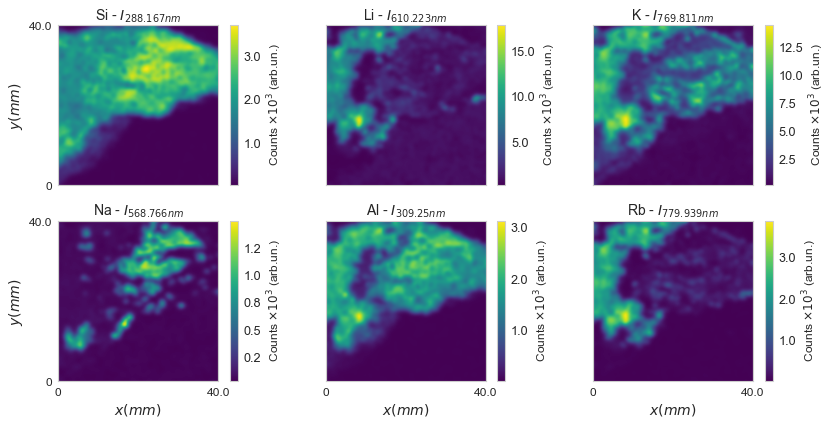

In [8]:
from matplotlib.ticker import FuncFormatter

fig,ax = subplots(2,3,figsize=[12,6])
i=0
nx,ny = 80, 80 
for j, (element, line) in enumerate(zip(lines, name_lines)):
    ix,iy = i//3,i%3
    if j in [0,3,6,9,12,15]:
        
        map_values1 = new_all_map_values[j]
        ax[ix,iy].set_title(name_lines[j]+ ' - $I_{' + str(lines[j])+'nm}$',fontsize=14)
        
        im = ax[ix,iy].imshow(np.transpose(np.array(map_values1).reshape((nx,ny)))/1e3, extent=[0,nx*0.5,0,ny*0.5],
                   cmap='viridis', interpolation = 'bicubic')#,interpolation='gaussian')
        if ix == 1:
            ax[ix,iy].set_xlabel(r'$x (mm)$',fontsize=14)
            ax[ix,iy].set_xticks([0,ny*0.5])
            ax[ix,iy].set_xticklabels([0,nx*0.5],fontsize=12)
        else:
            ax[ix,iy].set_xticks([])
        if iy == 0:
            ax[ix,iy].set_ylabel(r'$y (mm)$',fontsize=14)
            ax[ix,iy].set_yticks([0,nx*0.5])
            ax[ix,iy].set_yticklabels([0,ny*0.5],fontsize=12)
        else:
            ax[ix,iy].set_yticks([])
        fmt = lambda x, pos: '{:.1f}'.format(x)
        cb = colorbar(im,ax = ax[ix,iy],format=FuncFormatter(fmt))
        cb.set_label(r' Counts $\times 10^3$ (arb.un.)',size=12)
        i+=1
        
tight_layout()

# HSI data loading

In [11]:
filen = 'Cavali_amostras_test_A2_2022-05-31_12-38-48'
filen = 'Cavali_amostras_test_A3_2022-05-31_12-40-21'
folder = 'D:/Data/Data_HSI/SWIR_' + filen + '/capture/'


dark_ref = envi.open(folder+'DARKREF_SWIR_' + filen + '.hdr', 
                     folder+'DARKREF_SWIR_' + filen + '.raw')
white_ref = envi.open(folder+'WHITEREF_SWIR_' + filen + '.hdr', 
                      folder+'WHITEREF_SWIR_' + filen + '.raw')
data_ref = envi.open(folder+'SWIR_' + filen + '.hdr', 
                     folder+'SWIR_' + filen + '.raw')

c:\Users\tomas\Anaconda3\lib\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


In [12]:
white_nparr = np.array(white_ref.load())
dark_nparr = np.array(dark_ref.load())
data_nparr = np.array(data_ref.load())
print(white_nparr.shape,dark_nparr.shape, data_nparr.shape)

corrected_nparr = np.divide(data_nparr-dark_nparr.mean(axis=0),white_nparr.mean(axis=0)-dark_nparr.mean(axis=0)) #from reference

(100, 384, 284) (100, 384, 284) (354, 384, 284)


c:\Users\tomas\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


# Alignment of LIBS and HSI Acquisitions

In [13]:
im1 = corrected_nparr[100:250,100:320,200]
mmap = np.array(all_map_values)[10].reshape(nx, ny)

In [14]:
new_hyper = np.zeros((mmap.shape[0], mmap.shape[1], corrected_nparr.shape[-1]))

R = np.array([[-0.99992178, -0.0125076 ,  0.        ],[ 0.0125076 , -0.99992178,  0.        ],[ 0.        ,  0.        ,  1.        ]])
S = 1.0432286827553547
T = [118.13000331, 106.66730545,   0.        ]
    
for i in range(0, mmap.shape[0]):
    hyper_aligned = corrected_nparr[100:250, 100:320, :]
    for j in range(0, mmap.shape[1]):
        vec = np.array(T) + S * R @ np.array([i, j, 0])
        new_i,new_j = int(vec[0]), int(vec[1])
        try:
            new_hyper[i, j, :] = hyper_aligned[new_j, new_i]
        except:
            pass

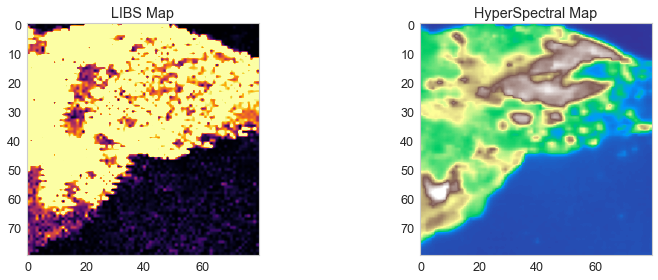

In [15]:
%matplotlib inline

band = 200
fig, ax = subplots(1, 2, figsize = (12, 4), tight_layout = True)
ax[0].imshow(np.array(all_map_values)[4].reshape(nx, ny).T, cmap = 'inferno', vmax = 12000)
ax[0].set_title('LIBS Map')
ax[0].grid()
ax[1].imshow(new_hyper[:, :, band].T, cmap = 'terrain', vmax = 0.8)
ax[1].set_title('HyperSpectral Map')
ax[1].grid()

In [16]:
end_band = -20
ffs = noise.SavitzkyGolay().denoise_bands(new_hyper[:, :, :end_band], 5, 3) 
ffs = np.array(ffs)
index = np.where(ffs < 0.1) #had it at 0.05 but shadows were forming in clustering
ffs[index] = 0

In [17]:
bands = data_ref.bands.centers

end_band = -20

feats_wls = []
signals = [np.ndarray.flatten(ffs[ii,jj,:]) for ii in range(0, new_hyper.shape[0]) for jj in range(0, new_hyper.shape[1]) ]

for xy in tqdm(range(0, len(signals))):
    #print('\r', xy, ' of ', str(len(signals)), end='')
    
    try:
        norm, x_hull, y_hull = spectro.convex_hull_removal(signals[xy], bands[ :end_band])
        features = spectro.FeaturesConvexHullQuotient(list(signals[xy]), bands[:end_band], startContinuum = None,
                                                     stopContinuum = None, baseline = 0.8, normalize = False)
        current_depth = 0
        current_wvl = 0
        for f in range(0, features.get_number_of_kept_features()):
            feat = features.features[f]
            if feat['abs_wvl'] > 2000 and feat['abs_depth'] > current_depth:
                current_wvl = feat['abs_wvl']
                current_depth = feat['abs_depth']
    except: 
        current_wvl = 0
        norm = signals[xy]
    
    feats_wls.append(current_wvl)
    signals[xy] = norm

100%|██████████| 6400/6400 [00:59<00:00, 107.24it/s]


In [18]:
s_signals = np.array(signals)
index = np.where(np.isnan(s_signals))
s_signals[index] = 1 #Maybe some bug taking data that made some points nan...setting them to 1

new_signals = np.array(s_signals).reshape((new_hyper.shape[0], new_hyper.shape[1], len(s_signals[0])))

#We need to get each wavelenght as a feature
list_of_wvls = np.array([np.ndarray.flatten(new_signals[:, :, i]) for i in range(0, len(new_signals[0, 0, :]))]).T

# Model training for Sensor Fusion

## Mineral composition to use as initialization for KMeans on LIBS

In [19]:
name_lines=['Si', 'Si', 'Si', 'Li','Li','Li', 'K', 'K', 'K','Na','Na','Na','Al', 'Al', 'Al',
            'Rb', 'Rb']

Si = [1,1,1]
Li = [1,1,1]
K = [1,1,1]
Na = [1,1,1]
Al = [1,1,1]
Rb = [1,1]
empt3 = [0,0,0]
empt2 = [0,0]
empt4 = [0,0,0,0]

# Describe each mineral according to their element composition using the order: [Si, Li, K, Na, Al, Rb]
# If some mineral is not present use empt

lepidolite = np.concatenate([Si, Li, K, empt3, Al, Rb])
background = np.concatenate([empt3, empt3, empt3, empt3, empt3, empt2])
quartz = np.concatenate([Si, empt3, empt3, empt3, empt3, empt2])
albite = np.concatenate([Si, empt3, empt3, Na, Al, empt2])
mica = np.concatenate([Si, empt3, K, empt3, Al, empt2])
hsi = np.concatenate([empt4])

k_means_init = np.array([lepidolite, background, albite, quartz, mica])

## Train

### LIBS

In [20]:
nclusters = 5
cluster_model = sklearn.cluster.KMeans(n_clusters = 5, init = k_means_init)

scaler1 = sklearn.preprocessing.MaxAbsScaler()
new_list_of_spectrums = scaler1.fit_transform(list_of_spectrums)
cluster_index = cluster_model.fit_predict(new_list_of_spectrums)

c:\Users\tomas\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:984: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


### HSI

In [21]:
pca_pip = sklearn.decomposition.PCA(n_components = 5)
pcs = pca_pip.fit_transform(list_of_wvls)
kmean_pip = sklearn.cluster.KMeans(n_clusters = 5, random_state = 13)
pca_km_pred = kmean_pip.fit_predict(pcs[:, :])

### MSKD

In [22]:
plsr = PLSRegression(n_components = 17)
plsr.fit(list_of_wvls, pd.get_dummies(cluster_index).to_numpy())

pls_da = plsr.predict(list_of_wvls)
pls_pred = pls_da.argmax(axis = 1)

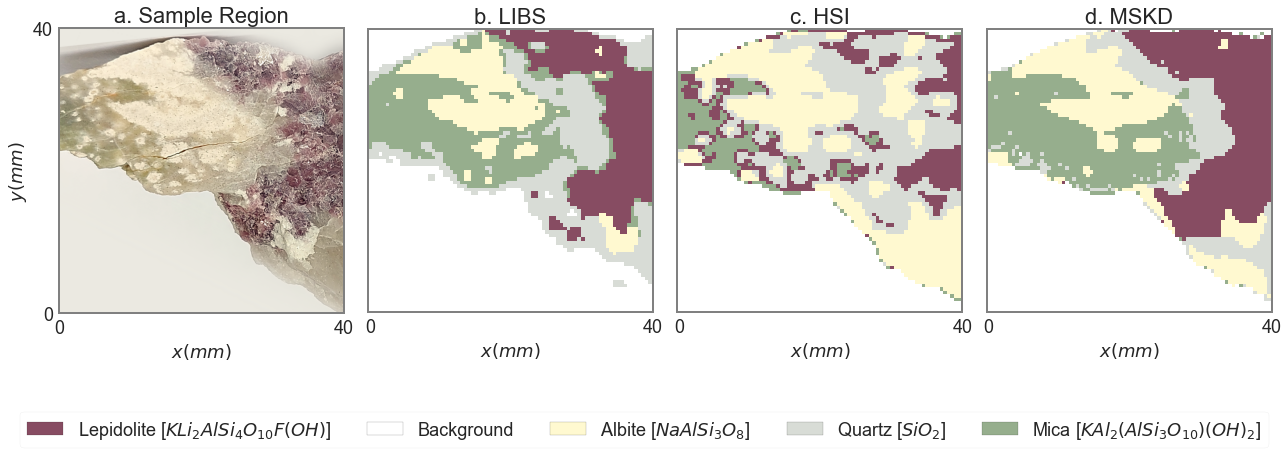

In [52]:
colors = ['xkcd:dark mauve', 'xkcd:white',  'xkcd:pale' , 'xkcd:light grey','xkcd:greenish grey']

#colors = ['Purple', 'ghostwhite',  'lightgoldenrodyellow' , 'silver','darkseagreen']
cmp_init = ListedColormap(colors[:nclusters])

colors = ['xkcd:light grey', 'xkcd:white',  'xkcd:greenish grey' , 'xkcd:pale','xkcd:dark mauve']
cmp_hsi = ListedColormap(colors[:nclusters])

# colors = ['Purple', 'ghostwhite',  'silver' , 'lightgoldenrodyellow','darkseagreen']
# cmp_coll = ListedColormap(colors[:nclusters])

nx, ny = 80, 80
matplotlib.rcParams['axes.linewidth'] = 2
matplotlib.rcParams['axes.edgecolor'] = '0.5'

import matplotlib.patches as mpatches
fig, ax = subplots(1, 4, figsize = (18, 8))

axs = ax[1]
axs.imshow(np.flip(cluster_index.reshape(nx, ny).T[::, ::-1], axis = 0), cmap = cmp_init, origin='lower')
axs.set_title("b. LIBS", fontsize = 22)
axs.grid(False)
axs.set_xlabel(r'$x(mm)$',fontsize=18)
# axs.set_ylabel(r'$y(mm)$',fontsize=18)
axs.set_xticks([0,nx])
axs.set_xticklabels([0,int(nx/2)],fontsize=18)
axs.set_yticks([])
# axs.set_yticklabels([0,int(nx/2)],fontsize=18)

axs = ax[2]
axs.imshow(np.flip(pca_km_pred.reshape(nx, ny).T[::, ::-1], axis = 0), cmap = cmp_hsi, origin='lower')
axs.set_title("c. HSI", fontsize = 22)
axs.grid(False)
axs.set_xlabel(r'$x(mm)$',fontsize=18)
# axs.set_ylabel(r'$y(mm)$',fontsize=18)
axs.set_xticks([0,nx])
axs.set_xticklabels([0,int(nx/2)],fontsize=18)
axs.set_yticks([])
# axs.set_yticklabels([0,int(nx/2)],fontsize=18)

axs = ax[3]
axs.imshow(np.flip(pls_pred.reshape(nx, ny).T[::, ::-1], axis = 0), cmap = cmp_init, origin='lower')
axs.set_title("d. MSKD", fontsize = 22)
axs.grid(False)
axs.set_xlabel(r'$x(mm)$',fontsize=18)
# axs.set_ylabel(r'$y(mm)$',fontsize=18)
axs.set_xticks([0,nx])
axs.set_xticklabels([0,int(nx/2)],fontsize=18)
axs.set_yticks([])
# axs.set_yticklabels([0,int(nx/2)],fontsize=18)

axs = ax[0]
axs.imshow(np.array(Image.open("C:/Users/tomas/Desktop/Tomás/Thesis/Data/image_bife.png"))[300:1700, 200:1600][::, ::], origin = 'lower')
axs.set_title("a. Sample Region", fontsize = 22)
axs.grid(False)
axs.set_xlabel(r'$x(mm)$',fontsize=18)
axs.set_ylabel(r'$y(mm)$',fontsize=18)
axs.set_xticks([0,1400])
axs.set_xticklabels([0,int(nx/2)],fontsize=18)
axs.set_yticks([0,1400])
axs.set_yticklabels([0,int(nx/2)],fontsize=18)

minerals = [r'Lepidolite [$KLi_2AlSi_4O_{10}F(OH)$]',r'Background',r'Albite [$NaAlSi_3O_8$]',r'Quartz [$SiO_2$]',r'Mica [$KAl_2(AlSi_3O_{10})(OH)_2$]']
# colors = ['xkcd:neon purple', 'xkcd:white',  'xkcd:ecru' , 'xkcd:silver','xkcd:sage']
colors = ['xkcd:dark mauve', 'xkcd:white',  'xkcd:pale' , 'xkcd:light grey','xkcd:greenish grey']
handles = []

hls = []
for color,mineral in zip(colors,minerals):
    patch = mpatches.Patch(color=color, label=mineral,ec='k')
    hls.append(patch)

fig.legend(handles=hls,loc = 'lower center',ncol=5, fontsize = 18)


tight_layout()

# savefig(r'C:/Users/tomas/Desktop/results_libs_hsi.jpg', transparent = False, dpi = 300, bbox_inches = 'tight')

## Interpreting Results by Analising mean feature values of LIBS and average HSI spectra for each cluster

In [31]:
cent_hsi_only = []
std_hsi_only = []

for i in range(0, len(np.unique(pca_km_pred))):
    cluster_i = np.where(pca_km_pred == i)
    cent_hsi_only.append(np.mean(list_of_wvls[cluster_i, :][0], axis = 0))
    std_hsi_only.append(np.std(list_of_wvls[cluster_i, :][0], axis = 0))

cent_hsi_only = np.array(cent_hsi_only)
std_hsi_only = np.array(std_hsi_only)

In [32]:
cent_libs_only = []

for i in range(0, len(np.unique(cluster_index))):
    cluster_i = np.where(cluster_index == i)
    cent_libs_only.append(np.mean(new_list_of_spectrums[cluster_i, :][0], axis = 0))

cent_libs_only = np.array(cent_libs_only)

In [33]:
cent_hsi = []
cent_libs = []
std_hsi = []

for i in range(0, len(np.unique(pls_pred))):
    cluster_i = np.where(pls_pred == i)
    cent_hsi.append(np.mean(list_of_wvls[cluster_i, :][0], axis = 0))
    std_hsi.append(np.std(list_of_wvls[cluster_i, :][0], axis = 0))
    cent_libs.append(np.mean(new_list_of_spectrums[cluster_i, :][0], axis = 0))

cent_hsi = np.array(cent_hsi)
cent_libs = np.array(cent_libs)
std_hsi = np.array(std_hsi)

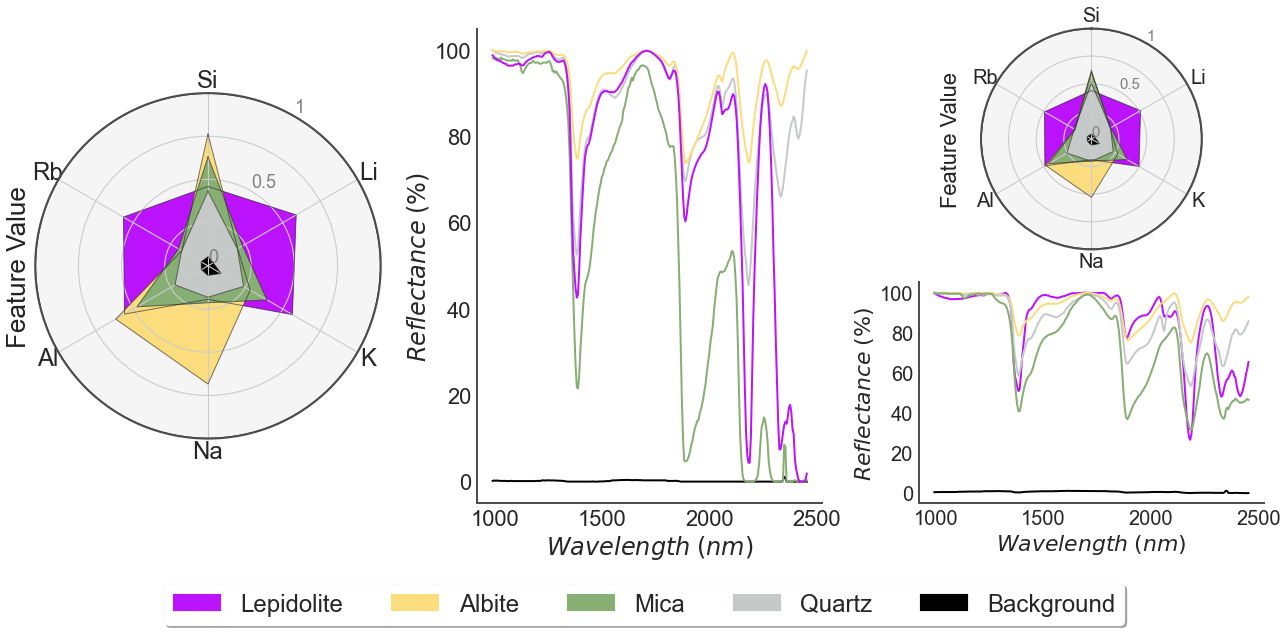

In [34]:
%matplotlib inline

fig = figure(figsize = (18, 8))
matplotlib.rcParams['axes.edgecolor'] = '0.3'
matplotlib.rcParams['axes.linewidth'] = 2
G = GridSpec(2,3)
axs = fig.add_subplot(G[0, 2], polar = True)

# colors = ['mediumorchid', 'black',  'wheat' , 'silver','darkseagreen']
colors = ['xkcd:neon purple', 'xkcd:black',  'xkcd:wheat' , 'xkcd:silver','xkcd:sage']
label = ['Lepidolite', 'Background', 'Albite', 'Quartz', 'Mica']

colors_hsi = ['xkcd:silver', 'xkcd:black',  'xkcd:sage' , 'xkcd:wheat', 'xkcd:neon purple']
label_hsi = ['Lepidolite', 'Background', 'Mica', 'Albite', 'Quartz']

N = 6
categories = name_lines[1::3]

angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

axs.set_theta_offset(np.pi / 2)
axs.set_theta_direction(-1)
axs.set_xticks(angles[:-1])
axs.set_xticklabels(categories,size=20)
axs.set_rlabel_position(30)
axs.set_yticks([0,0.25,0.5,0.75,1])
axs.set_yticklabels(["0","","0.5","","1"], size=15,c='grey')
axs.set_ylim(0, top = 1)
iis = [0,2,4,3,1]
# iis = [4, 0, 3, 2, 1]

for i in iis:
    center = cent_libs[i]
    values=[np.mean(center[j*3:j*3+3]) for j in range(0,6)]
    values += values[:1]
    axs.plot(angles, values,color='k',lw=1,alpha=0.6,ls='-') #, label=minerals[i]
    axs.fill(angles, values, color=colors[i], alpha=1, label = label[i])

axs.yaxis.get_gridlines()[-1].set_color("k")
axs.yaxis.get_gridlines()[-1].set_linewidth(2)
axs.set_ylabel('Feature Value',fontsize=22,c='k', labelpad=20)

axs.set_facecolor("whitesmoke")
fig.set_facecolor("white")
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0),
          fancybox=True, shadow=True, ncol=5, fontsize = 24)
# Add legend
# hls = []
# for color,mineral in zip(colors,minerals):
#     patch = mpatches.Patch(color=color, label=mineral,ec='k')
#     hls.append(patch)
# axs.legend(handles=hls,loc = 'upper right',  bbox_to_anchor=(-0.05, 0.5),ncol=1,title='Mineral Type')
# axs.set_title("LIBS", fontsize = 22)


axs = fig.add_subplot(G[1, 2],polar = False)
for i in range(0, cent_hsi.shape[0]):
    err = std_hsi[i]*100
    plot(bands[:-20], cent_hsi[i]*100, color = colors[i], label = label[i], lw = 2)
    #fill_between(bands[:-20], cent_hsi[i]*100 - err, cent_hsi[i]*100 + err, color = colors[i], alpha = 0.2)


axs.grid(False)
axs.spines[['right', 'top']].set_visible(False)
axs.set_xlabel(r'$Wavelength \; (nm)$', fontsize = 22)
axs.set_ylabel(r'$Reflectance \; (\%)$', fontsize = 22)
axs.set_yticks([0, 20, 40, 60, 80, 100], [0, 20, 40, 60, 80, 100], fontsize = 20)
axs.set_xticks([1000,1500, 2000, 2500],[1000,1500, 2000, 2500], fontsize = 20)

axs = fig.add_subplot(G[:, 1], polar = False)
for i in range(0, cent_hsi.shape[0]):
    err = std_hsi_only[i]*100
    plot(bands[:-20], cent_hsi_only[i]*100, color = colors_hsi[i], label = label_hsi[i], lw = 2)
    #fill_between(bands[:-20], cent_hsi_only[i]*100 - err, cent_hsi_only[i]*100 + err, color = colors_hsi[i], alpha = 0.2)

axs.grid(False)
axs.spines[['right', 'top']].set_visible(False)
axs.set_xlabel(r'$Wavelength \; (nm)$', fontsize = 24)
axs.set_ylabel(r'$Reflectance \; (\%)$', fontsize = 24)
axs.set_yticks([0, 20, 40, 60, 80, 100], [0, 20, 40, 60, 80, 100], fontsize = 22)
axs.set_xticks([1000,1500, 2000, 2500],[1000,1500, 2000, 2500], fontsize = 22)

axs = fig.add_subplot(G[:, 0], polar = True)

colors = ['xkcd:neon purple', 'xkcd:black',  'xkcd:wheat' , 'xkcd:silver','xkcd:sage']
label = ['Lepidolite', 'Background', 'Albite', 'Quartz', 'Mica']

N = 6
categories = name_lines[1::3]

angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

axs.set_theta_offset(np.pi / 2)
axs.set_theta_direction(-1)
axs.set_xticks(angles[:-1])
axs.set_xticklabels(categories,size=24)
axs.set_rlabel_position(30)
axs.set_yticks([0,0.25,0.5,0.75,1])
axs.set_yticklabels(["0","","0.5","","1"], size=18,c='grey')
axs.set_ylim(0, top = 1)
iis = [0,2,4,3,1]

for i in iis:
    center = cent_libs_only[i]
    values=[np.mean(center[j*3:j*3+3]) for j in range(0,6)]
    values += values[:1]
    axs.plot(angles, values,color='k',lw=1,alpha=0.6,ls='-') #, label=minerals[i]
    axs.fill(angles, values, color=colors[i], alpha=1, label = label[i])

axs.yaxis.get_gridlines()[-1].set_color("k")
axs.yaxis.get_gridlines()[-1].set_linewidth(2)
axs.set_ylabel('Feature Value',fontsize=26,c='k')

axs.set_facecolor("whitesmoke")


tight_layout()
# fig.savefig(r'C:/Users/tomas/Desktop/new_images/interpretability_new.jpg', dpi = 500, bbox_inches='tight', transparent = False)

# Generalization

In [35]:
filen = 'Cavali_amostras_test_A2_2022-05-31_12-38-48'
folder = 'D:/Data/Data_HSI/SWIR_' + filen + '/capture/'


dark_ref = envi.open(folder+'DARKREF_SWIR_' + filen + '.hdr', 
                     folder+'DARKREF_SWIR_' + filen + '.raw')
white_ref = envi.open(folder+'WHITEREF_SWIR_' + filen + '.hdr', 
                      folder+'WHITEREF_SWIR_' + filen + '.raw')
data_ref = envi.open(folder+'SWIR_' + filen + '.hdr', 
                     folder+'SWIR_' + filen + '.raw')

c:\Users\tomas\Anaconda3\lib\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


In [36]:
white_nparr = np.array(white_ref.load())
dark_nparr = np.array(dark_ref.load())
data_nparr = np.array(data_ref.load())
print(white_nparr.shape,dark_nparr.shape, data_nparr.shape)

corrected_nparr = np.divide(data_nparr-dark_nparr.mean(axis=0),white_nparr.mean(axis=0)-dark_nparr.mean(axis=0)) #from reference

(100, 384, 284) (100, 384, 284) (354, 384, 284)


c:\Users\tomas\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
c:\Users\tomas\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


In [37]:
test_hyper = corrected_nparr[45:250, 50:370, :]

end_band = -20
ffs = noise.SavitzkyGolay().denoise_bands(test_hyper[:, :, :end_band], 5, 3) 
ffs = np.array(ffs)
index = np.where(ffs < 0.1) 
ffs[index] = 0

In [38]:
bands = data_ref.bands.centers

end_band = -20

feats_wls = []
signals = [np.ndarray.flatten(ffs[ii,jj,:]) for ii in range(0, ffs.shape[0]) for jj in range(0, ffs.shape[1]) ]

for xy in tqdm(range(0, len(signals))):
    #print('\r', xy, ' of ', str(len(signals)), end='')
    
    try:
        norm, x_hull, y_hull = spectro.convex_hull_removal(signals[xy], bands[ :end_band])
        features = spectro.FeaturesConvexHullQuotient(list(signals[xy]), bands[:end_band], startContinuum = None,
                                                     stopContinuum = None, baseline = 0.8, normalize = False)
        current_depth = 0
        current_wvl = 0
        for f in range(0, features.get_number_of_kept_features()):
            feat = features.features[f]
            if feat['abs_wvl'] > 2000 and feat['abs_depth'] > current_depth:
                current_wvl = feat['abs_wvl']
                current_depth = feat['abs_depth']
    except: 
        current_wvl = 0
        norm = signals[xy]
    
    feats_wls.append(current_wvl)
    signals[xy] = norm

100%|██████████| 65600/65600 [11:00<00:00, 99.26it/s] 


In [39]:
s_signals = np.array(signals)
index = np.where(np.isnan(s_signals))
s_signals[index] = 1 #Maybe some bug taking data that made some points nan...setting them to 1

new_signals = np.array(s_signals).reshape((ffs.shape[0], ffs.shape[1], len(s_signals[0])))

#We need to get each wavelenght as a feature
test_list_of_wvls = np.array([np.ndarray.flatten(new_signals[:, :, i]) for i in range(0, len(new_signals[0, 0, :]))]).T

In [40]:
# PCA-Kmeans
pcs = pca_pip.transform(test_list_of_wvls)
pca_km_pred_other = kmean_pip.predict(pcs)

# PCA-DA
pls_da_pred_other = plsr.predict(test_list_of_wvls).argmax(axis = 1)

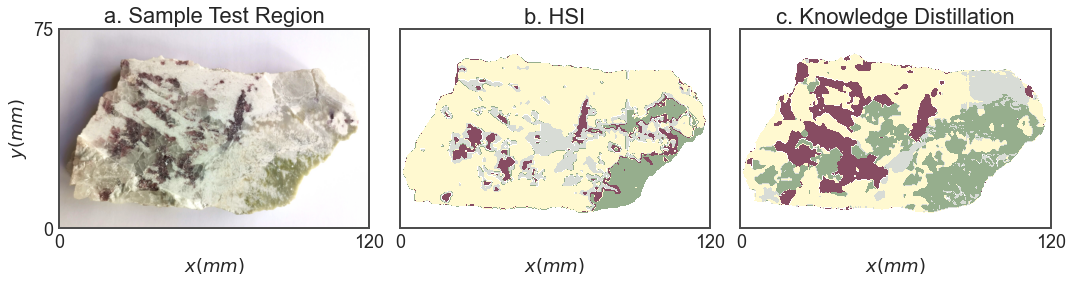

In [47]:
fig, ax = subplots(1, 3, figsize = (15, 8))

# colors = ['Purple', 'ghostwhite',  'lightgoldenrodyellow' , 'silver','darkseagreen']
colors = ['xkcd:neon purple', 'xkcd:white',  'xkcd:ecru' , 'xkcd:silver','xkcd:sage']

axs = ax[0]
axs.imshow(np.array(Image.open("D:/Images/Articles/Unfinished/IMG_20230302_153550.jpg"))[::, ::-1][450:2635, 0:3400][::, ::-1], origin = 'lower')
axs.set_title("a. Sample Test Region", fontsize = 22)
axs.grid(False)
axs.set_ylabel(r'$y(mm)$',fontsize=18)
axs.set_xlabel(r'$x(mm)$',fontsize=18)
axs.set_xticks([0,3400])
axs.set_xticklabels([0,120],fontsize=18)
axs.set_yticks([0,2185])
axs.set_yticklabels([0,75],fontsize=18)

axs = ax[1]
axs.imshow(pca_km_pred_other.reshape(205, 320)[::-1, ::][::, ::-1], cmap = cmp_hsi, origin = 'lower')
axs.set_title("b. HSI", size = 22)
axs.grid(False)
axs.set_xlabel(r'$x(mm)$',fontsize=18)
axs.set_xticks([0,320])
axs.set_xticklabels([0,120],fontsize=18)
axs.set_yticks([])

axs = ax[2]
axs.imshow(pls_da_pred_other.reshape(205, 320)[::-1, ::][::, ::-1], cmap = cmp_init, origin = 'lower')
axs.set_title("c. Knowledge Distillation", size = 22)
axs.grid(False)
axs.set_xlabel(r'$x(mm)$',fontsize=18)
axs.set_xticks([0,320])
axs.set_xticklabels([0,120],fontsize=18)
axs.set_yticks([])

fig.tight_layout()
fig.savefig(r'C:/Users/tomas/Desktop/secondary_results.jpg', dpi = 300, bbox_inches='tight')

# Outro

In [43]:
data_folder = r"C:/Users/tomas/Desktop/Tomás/Thesis/Data/"
hf = h5py.File(data_folder + 'mini_bife_100x110.h5', 'r')
spectrums_test = np.array(hf.get('intensities'))
positions_test = np.array(hf.get('position'))
wavelengths_test = np.array(hf.get('wavelengths'))
hf.close()

In [56]:
map_experiments_test = [spectrums_test]

all_x_values_test = []
all_y_values_test = []
all_map_values_test = []

for ii in tqdm(range(0,len(lines))):
    line1=lines[ii]
    for j in range(0,1):#len(map_experiments)
        current_experiment_test = map_experiments_test[j]

        x_values_t,y_values_t,map_values_t =  make_map_intensity_hdf5(current_experiment_test, positions_test, wavelengths_test, line1, radius=1)

        all_x_values_test.append(x_values_t)
        all_y_values_test.append(y_values_t)
        all_map_values_test.append(map_values_t)


if ratios == True:  
    for i in range(3):
        all_x_values_test.append(x_values_t)
        all_y_values_test.append(y_values_t)

    all_map_values_test.append(np.array(all_map_values_test[12])/np.array(all_map_values_test[3]))
    all_map_values_test.append(np.array(all_map_values_test[12])/np.array(all_map_values_test[0]))
    all_map_values_test.append(np.array(all_map_values_test[3])/np.array(all_map_values_test[0]))

    name_lines.append('Al/Li')
    name_lines.append('Al/Si')
    name_lines.append('Li/Si')
    lines.append('309.25/610.22')
    lines.append('309.25/288.13')
    lines.append('610.22/288.13')

if gaussian_filter == True:
    new_all_map_values_test = skimage.filters.gaussian(np.transpose(np.array(
        all_map_values_test).reshape((np.array(all_map_values_test).shape[0],
                                    len(np.unique(x_values_t)),
                                    len(np.unique(y_values_t)))),axes=(2,1,0)), sigma=1)

    new_all_map_values_test = np.transpose(new_all_map_values_test,axes=(2,1,0))
    new_all_map_values_test = new_all_map_values_test.reshape((np.array(all_map_values_test).shape[0],
                                                        len(np.unique(x_values_t))*
                                                        len(np.unique(y_values_t))))

    list_of_spectrums_test = np.transpose(np.array(new_all_map_values_test))
    print(list_of_spectrums_test.shape)

else:
    list_of_spectrums_test = np.transpose(np.array(all_map_values_test))
    print(list_of_spectrums_test.shape)

new_list_of_spectrums_test = scaler1.fit_transform(list_of_spectrums_test)

  0%|          | 0/17 [00:00<?, ?it/s]

100%|██████████| 17/17 [00:41<00:00,  2.46s/it]

(11000, 17)


In [45]:
nx, ny = 100, 110

im1 = corrected_nparr[100:250,100:320,200]
mmap = np.array(all_map_values_test)[10].reshape(nx, ny)

In [46]:
new_hyper = np.zeros((mmap.shape[0], mmap.shape[1], corrected_nparr.shape[-1]))

R = np.array([[ 0.99375432,  0.11159007,  0.        ],[ 0.11159007, -0.99375432,  0.        ],[ 0.        ,  0.        , -1.        ]])
S = 1.0289317044580675
T = np.array([104.06239868, 114.06316926,   0.        ])
    
for i in range(0, mmap.shape[0]):
    hyper_aligned = corrected_nparr[100:250, 100:320, :]
    for j in range(0, mmap.shape[1]):
        vec = np.array(T) + S * R @ np.array([i, j, 0])
        new_i,new_j = int(vec[0]), int(vec[1])
        try:
            new_hyper[i, j, :] = hyper_aligned[new_j, new_i]
        except:
            pass

In [47]:
end_band = -20
ffs = noise.SavitzkyGolay().denoise_bands(new_hyper[:, :, :end_band], 5, 3) 
ffs = np.array(ffs)
index = np.where(ffs < 0.1) #had it at 0.05 but shadows were forming in clustering
ffs[index] = 0

In [48]:
bands = data_ref.bands.centers

end_band = -20

feats_wls = []
signals = [np.ndarray.flatten(ffs[ii,jj,:]) for ii in range(0, new_hyper.shape[0]) for jj in range(0, new_hyper.shape[1]) ]

for xy in tqdm(range(0, len(signals))):
    #print('\r', xy, ' of ', str(len(signals)), end='')
    
    try:
        norm, x_hull, y_hull = spectro.convex_hull_removal(signals[xy], bands[ :end_band])
        features = spectro.FeaturesConvexHullQuotient(list(signals[xy]), bands[:end_band], startContinuum = None,
                                                     stopContinuum = None, baseline = 0.8, normalize = False)
        current_depth = 0
        current_wvl = 0
        for f in range(0, features.get_number_of_kept_features()):
            feat = features.features[f]
            if feat['abs_wvl'] > 2000 and feat['abs_depth'] > current_depth:
                current_wvl = feat['abs_wvl']
                current_depth = feat['abs_depth']
    except: 
        current_wvl = 0
        norm = signals[xy]
    
    feats_wls.append(current_wvl)
    signals[xy] = norm

100%|██████████| 11000/11000 [02:39<00:00, 68.94it/s] 


In [49]:
s_signals = np.array(signals)
index = np.where(np.isnan(s_signals))
s_signals[index] = 1 #Maybe some bug taking data that made some points nan...setting them to 1

new_signals = np.array(s_signals).reshape((new_hyper.shape[0], new_hyper.shape[1], len(s_signals[0])))

#We need to get each wavelenght as a feature
list_of_wvls_test = np.array([np.ndarray.flatten(new_signals[:, :, i]) for i in range(0, len(new_signals[0, 0, :]))]).T

In [57]:
libs_coll = libs_st.transform(new_list_of_spectrums_test)

pcs_test = pca_pip.transform(list_of_wvls_test)

pcs = pca_coll.transform(list_of_wvls_test)
aligned_hyper_coll = hyper_scaler.transform(pcs)

new_data_test = np.column_stack([libs_coll, aligned_hyper_coll])

cluster_index_test = cluster_model.predict(new_list_of_spectrums_test)
cluster_hsi_test = kmean_pip.predict(pcs_test)
cluster_collaborative_test = cluster_coll.predict(new_data_test)

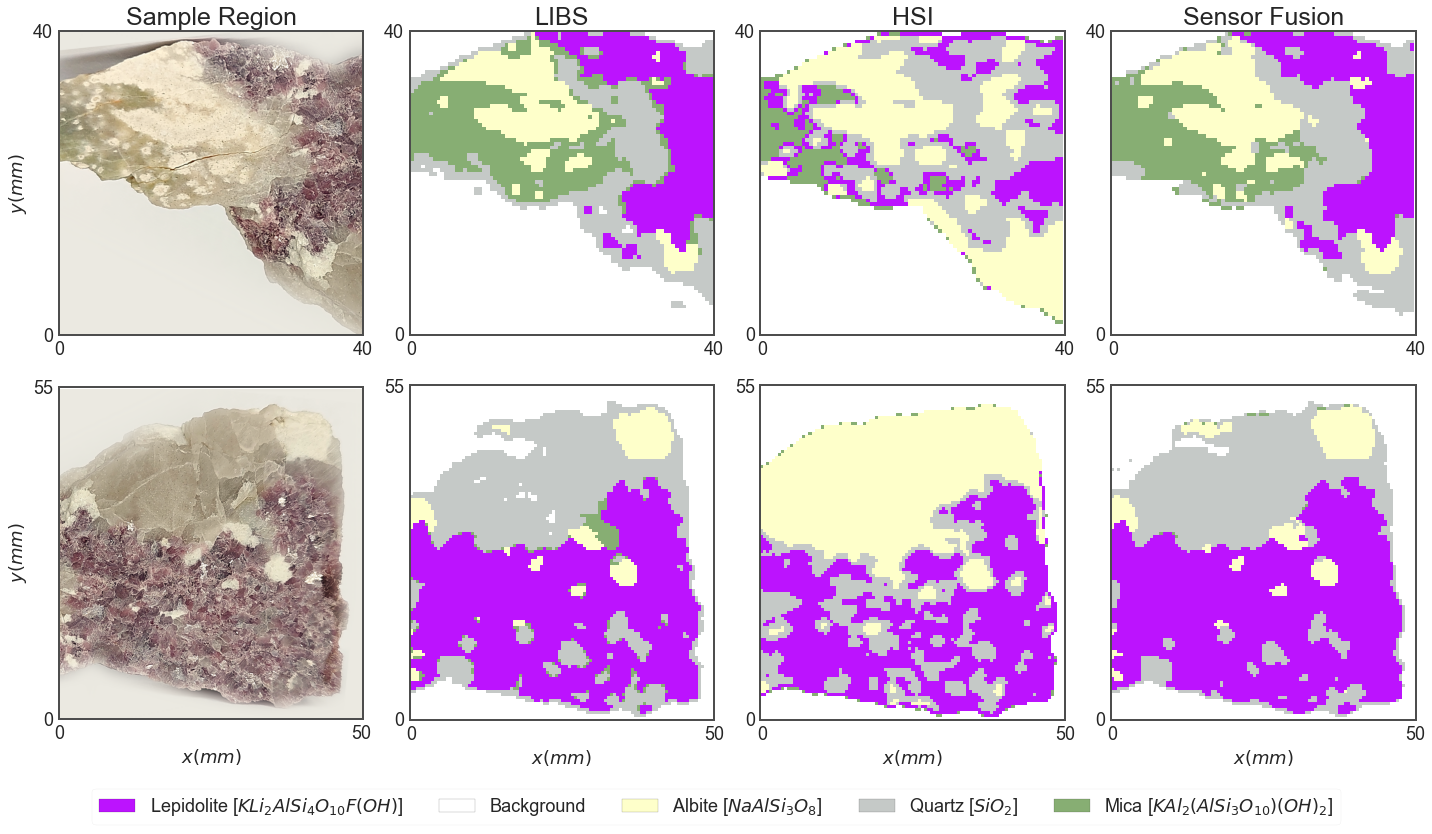

In [59]:
nx, ny = 80, 80


import matplotlib.patches as mpatches
fig, ax = subplots(2, 4, figsize = (20, 13))
subplots_adjust(hspace=-0.5)

axs = ax[0, 1]
axs.imshow(np.flip(cluster_index.reshape(nx, ny).T[::, ::-1], axis = 0), cmap = cmp_init, origin='lower')
axs.set_title("LIBS", fontsize = 25)
axs.grid(False)
# axs.set_xlabel(r'$x(mm)$',fontsize=18)
# axs.set_ylabel(r'$y(mm)$',fontsize=18)
axs.set_xticks([0,nx])
axs.set_xticklabels([0,int(nx/2)],fontsize=18)
axs.set_yticks([0,nx])
axs.set_yticklabels([0,int(nx/2)],fontsize=18)

axs = ax[0, 2]
axs.imshow(np.flip(pca_km_pred.reshape(nx, ny).T[::, ::-1], axis = 0), cmap = cmp_hsi, origin='lower')
axs.set_title("HSI", fontsize = 25)
axs.grid(False)
# axs.set_xlabel(r'$x(mm)$',fontsize=18)
# axs.set_ylabel(r'$y(mm)$',fontsize=18)
axs.set_xticks([0,nx])
axs.set_xticklabels([0,int(nx/2)],fontsize=18)
axs.set_yticks([0,nx])
axs.set_yticklabels([0,int(nx/2)],fontsize=18)

axs = ax[0, 3]
axs.imshow(np.flip(cluster_collaborative.reshape(nx, ny).T[::, ::-1], axis = 0), cmap = cmp_init, origin='lower')
axs.set_title("Sensor Fusion", fontsize = 25)
axs.grid(False)
# axs.set_xlabel(r'$x(mm)$',fontsize=18)
# axs.set_ylabel(r'$y(mm)$',fontsize=18)
axs.set_xticks([0,nx])
axs.set_xticklabels([0,int(nx/2)],fontsize=18)
axs.set_yticks([0,nx])
axs.set_yticklabels([0,int(nx/2)],fontsize=18)

axs = ax[0, 0]
axs.imshow(np.array(Image.open("C:/Users/tomas/Desktop/Tomás/Thesis/Data/image_bife.png"))[300:1700, 200:1600][::, ::], origin = 'lower')
axs.set_title("Sample Region", fontsize = 25)
axs.grid(False)
# axs.set_xlabel(r'$x(mm)$',fontsize=18)
axs.set_ylabel(r'$y(mm)$',fontsize=18)
axs.set_xticks([0,1400])
axs.set_xticklabels([0,int(nx/2)],fontsize=18)
axs.set_yticks([0,1400])
axs.set_yticklabels([0,int(nx/2)],fontsize=18)

nx, ny = 100, 110

axs = ax[1,1]
axs.imshow(np.flip(cluster_index_test.reshape(nx, ny).T[::-1, ::], axis = 0), cmap = cmp_init, origin='lower')
# axs.set_title("LIBS", fontsize = 20)
axs.grid(False)
axs.set_xlabel(r'$x(mm)$',fontsize=18)
# axs.set_ylabel(r'$y(mm)$',fontsize=18)
axs.set_xticks([0,nx])
axs.set_xticklabels([0,50],fontsize=18)
axs.set_yticks([0,ny])
axs.set_yticklabels([0,55],fontsize=18)

axs = ax[1,2]
axs.imshow(np.flip(cluster_hsi_test.reshape(nx, ny).T[::-1, ::], axis = 0), cmap = cmp_hsi, origin='lower')
# axs.set_title("HSI", fontsize = 20)
axs.grid(False)
axs.set_xlabel(r'$x(mm)$',fontsize=18)
# axs.set_ylabel(r'$y(mm)$',fontsize=18)
axs.set_xticks([0,nx])
axs.set_xticklabels([0,50],fontsize=18)
axs.set_yticks([0,ny])
axs.set_yticklabels([0,55],fontsize=18)

axs = ax[1,3]
axs.imshow(np.flip(cluster_collaborative_test.reshape(nx, ny).T[::-1, ::], axis = 0), cmap = cmp_init, origin='lower')
# axs.set_title("Sensor Fusion", fontsize = 20)
axs.grid(False)
axs.set_xlabel(r'$x(mm)$',fontsize=18)
# axs.set_ylabel(r'$y(mm)$',fontsize=18)
axs.set_xticks([0,nx])
axs.set_xticklabels([0,50],fontsize=18)
axs.set_yticks([0,ny])
axs.set_yticklabels([0,55],fontsize=18)

axs = ax[1,0]
axs.imshow(np.array(Image.open("C:/Users/tomas/Desktop/Tomás/Thesis/Data/image_bife.png"))[0:1900, 1250:-1][::-1, ::], origin = 'lower')
# axs.set_title("Sample Testing Region", fontsize = 20)
axs.grid(False)
axs.set_xlabel(r'$x(mm)$',fontsize=18)
axs.set_ylabel(r'$y(mm)$',fontsize=18)
axs.set_xticks([0,1700])
axs.set_xticklabels([0,50],fontsize=18)
axs.set_yticks([0,1870])
axs.set_yticklabels([0,55],fontsize=18)

minerals = [r'Lepidolite [$KLi_2AlSi_4O_{10}F(OH)$]',r'Background',r'Albite [$NaAlSi_3O_8$]',r'Quartz [$SiO_2$]',r'Mica [$KAl_2(AlSi_3O_{10})(OH)_2$]']
colors = ['xkcd:neon purple', 'xkcd:white',  'xkcd:ecru' , 'xkcd:silver','xkcd:sage']
handles = []

hls = []
for color,mineral in zip(colors,minerals):
    patch = mpatches.Patch(color=color, label=mineral,ec='k')
    hls.append(patch)

fig.legend(handles=hls,loc = 'lower center',ncol=5, fontsize = 18)


fig.tight_layout()
# savefig(r'C:/Users/tomas/Desktop/new_images/results_fusion_test_new.png', transparent = False, dpi = 500)

In [35]:
cent_hsi = []
cent_libs = []

for i in range(0, len(np.unique(cluster_collaborative_test))):
    cluster_i = np.where(cluster_collaborative_test == i)
    cent_hsi.append(np.mean(list_of_wvls_test[cluster_i, :][0], axis = 0))
    cent_libs.append(np.mean(new_list_of_spectrums_test[cluster_i, :][0], axis = 0))

cent_hsi = np.array(cent_hsi)
cent_libs = np.array(cent_libs)

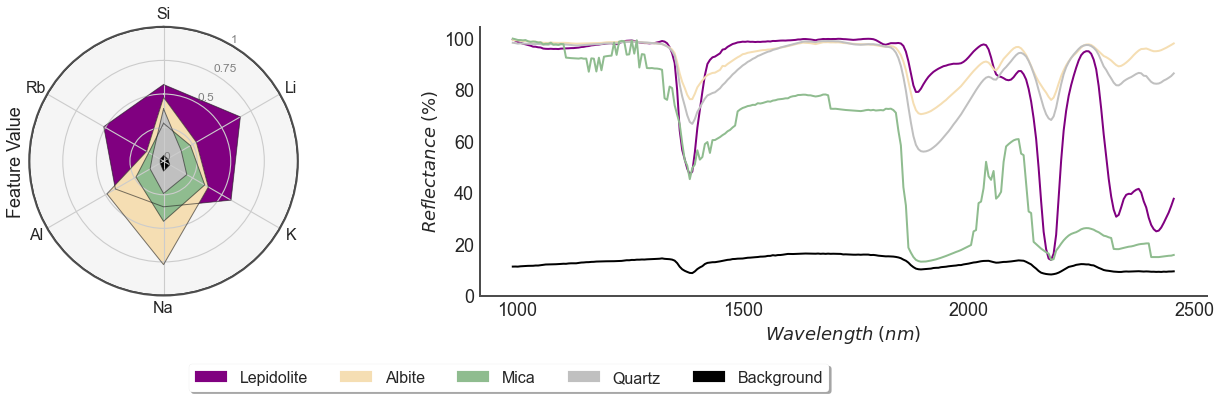

In [36]:
fig = figure(figsize = (20, 5))
G = GridSpec(1,2)
axs = fig.add_subplot(G[0],polar=True)

colors = ['Purple', 'black',  'wheat' , 'silver','darkseagreen']
label = ['Lepidolite', 'Background', 'Albite', 'Quartz', 'Mica']


N = 6
categories = name_lines[1::3]

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

axs.set_theta_offset(pi / 2)
axs.set_theta_direction(-1)
axs.set_xticks(angles[:-1])
axs.set_xticklabels(categories,size=16)
axs.set_rlabel_position(30)
axs.set_yticks([0,0.25,0.5,0.75,1])
axs.set_yticklabels(["0","","0.5","0.75","1"], size=12,c='grey')
axs.set_ylim(0, top = 1)
iis = [0,2,4,3,1]

for i in iis:
    center = cent_libs[i]
    values=[np.mean(center[j*3:j*3+3]) for j in range(0,6)]
    values += values[:1]
    axs.plot(angles, values,color='k',lw=1,alpha=0.6,ls='-') #, label=minerals[i]
    axs.fill(angles, values, color=colors[i], alpha=1, label = label[i])

axs.yaxis.get_gridlines()[-1].set_color("k")
axs.yaxis.get_gridlines()[-1].set_linewidth(2)
axs.set_ylabel('Feature Value',fontsize=18,c='k')

axs.set_facecolor("whitesmoke")
fig.set_facecolor("white")
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0),
          fancybox=True, shadow=True, ncol=5, fontsize = 16)
# Add legend
# hls = []
# for color,mineral in zip(colors,minerals):
#     patch = mpatches.Patch(color=color, label=mineral,ec='k')
#     hls.append(patch)
# axs.legend(handles=hls,loc = 'upper right',  bbox_to_anchor=(-0.05, 0.5),ncol=1,title='Mineral Type')
# axs.set_title("LIBS", fontsize = 22)


axs = fig.add_subplot(G[1],polar=False)
for i in range(0, cent_hsi.shape[0]):
    plot(bands[:-20], cent_hsi[i]*100, color = colors[i], label = label[i], lw = 2)


axs.grid(False)
axs.spines[['right', 'top']].set_visible(False)
axs.set_xlabel(r'$Wavelength \; (nm)$', fontsize = 18)
axs.set_ylabel(r'$Reflectance \; (\%)$', fontsize = 18)
axs.set_yticks([0, 20, 40, 60, 80, 100], [0, 20, 40, 60, 80, 100], fontsize = 18)
axs.set_xticks([1000,1500, 2000, 2500],[1000,1500, 2000, 2500], fontsize = 18)
matplotlib.rcParams['axes.edgecolor'] = '0.3'
matplotlib.rcParams['axes.linewidth'] = 2
# axs.set_title("HSI")
# fig.suptitle("Average Spectrum of the Identified Mineral Regions", fontsize = 20)


tight_layout()
# fig.savefig("interpretability_fusion.png", dpi = 500, bbox_inches='tight')

# Knowledge Distillation

### Train PLS-DA

In [35]:
from sklearn.model_selection import train_test_split,KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score

scores = []

x_train, x_test, y_train, y_test = train_test_split(list_of_wvls, pd.get_dummies(cluster_index).to_numpy(), test_size = 0.3, random_state = 13)

kf = KFold(n_splits=3,random_state=3,shuffle=True)
X = list_of_wvls
Y = pd.get_dummies(cluster_index).to_numpy()
for n_comp in tqdm(range(1, 80, 1)):
  curr_scores = []
  for i, (train_index, test_index) in enumerate(kf.split(list_of_wvls)):
    x_train, y_train = X[train_index], Y[train_index]
    x_test, y_test = X[test_index], Y[test_index]
    my_plsr = PLSRegression(n_components = n_comp)
    my_plsr.fit(x_train, y_train)
    preds = my_plsr.predict(x_test)
    score = accuracy_score(y_test.argmax(axis = 1), preds.argmax(axis = 1))
    score = f1_score(y_test.argmax(axis = 1), preds.argmax(axis = 1),average ='micro')
    curr_scores.append(score)
  scores.append(np.mean(curr_scores))

  0%|          | 0/79 [00:00<?, ?it/s]

 19%|█▉        | 15/79 [00:19<01:24,  1.32s/it]


KeyboardInterrupt: 

In [127]:
curr_scores

[0.8228678537956888, 0.8255977496483825, 0.8054383497421472]

Text(0, 0.5, 'Accuracy Score')

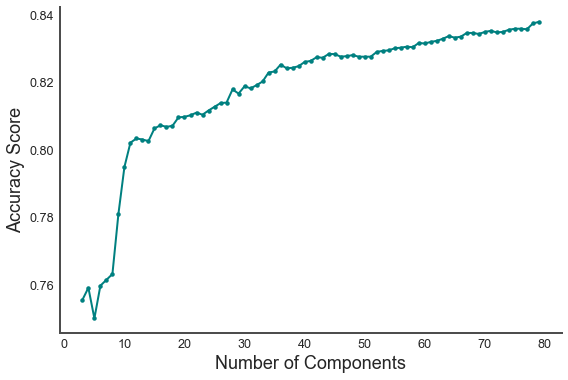

In [81]:
fig, axs = subplots(figsize = (9, 6))
x = np.arange(1, 80, 1)
axs.plot(x[2:], scores[2:], lw = 2, c = 'teal', marker = 'o', zorder=-1, ms = 4.5)
# axs.scatter(x[16], scores[16], s = 80, color = 'red', zorder=1)
axs.grid(False)
axs.spines[['right', 'top']].set_visible(False)
axs.set_xlabel(r'Number of Components', fontsize = 18)
axs.set_ylabel(r'Accuracy Score', fontsize = 18)
# xlim(0, 50)
# axs.set_xticks([0, 10, 20, 30, 40, 50], [0, 10, 20, 30, 40, 50], fontsize = 18)
# axs.set_ylim(0.88, 1.1)
# axs.set_yticks([0.90, 1, 1.10],[0.90, 1.0, 1.10], fontsize = 18)

# fig.savefig("predictive_error.png", dpi = 500, bbox_inches='tight')

Text(0, 0.5, 'Accuracy Score')

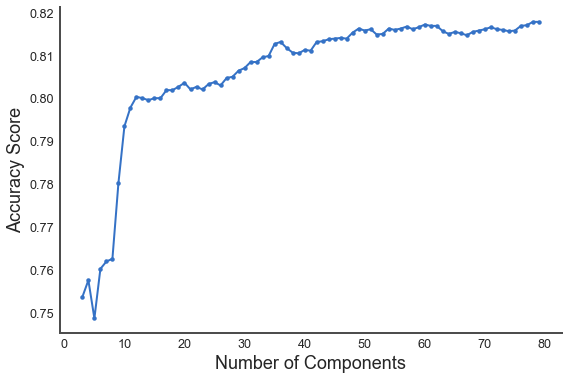

In [131]:
fig, axs = subplots(figsize = (9, 6))
x = np.arange(1, 80, 1)
axs.plot(x[2:], scores[2:], lw = 2, marker = 'o', zorder = -1, ms = 4.5)
# axs.scatter(x[16], scores[16], s = 80, color = 'red', zorder=1)
axs.grid(False)
axs.spines[['right', 'top']].set_visible(False)
axs.set_xlabel(r'Number of Components', fontsize = 18)
axs.set_ylabel(r'Accuracy Score', fontsize = 18)
# xlim(0, 50)
# axs.set_xticks([0, 10, 20, 30, 40, 50], [0, 10, 20, 30, 40, 50], fontsize = 18)
# axs.set_ylim(0.88, 1.1)
# axs.set_yticks([0.90, 1, 1.10],[0.90, 1.0, 1.10], fontsize = 18)

# fig.savefig("predictive_error.png", dpi = 500, bbox_inches='tight')

Text(0, 0.5, 'Accuracy Score')

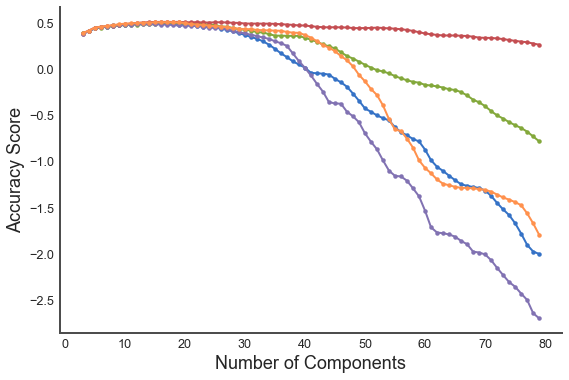

In [92]:
fig, axs = subplots(figsize = (9, 6))
x = np.arange(1, 80, 1)
axs.plot(x[2:], scores[2:], lw = 2, marker = 'o', zorder=-1, ms = 4.5)
# axs.scatter(x[16], scores[16], s = 80, color = 'red', zorder=1)
axs.grid(False)
axs.spines[['right', 'top']].set_visible(False)
axs.set_xlabel(r'Number of Components', fontsize = 18)
axs.set_ylabel(r'Accuracy Score', fontsize = 18)

In [60]:
plsr = PLSRegression(n_components = 17)
plsr.fit(list_of_wvls, pd.get_dummies(cluster_index).to_numpy())

pls_da = plsr.predict(list_of_wvls)
pls_pred = pls_da.argmax(axis = 1)

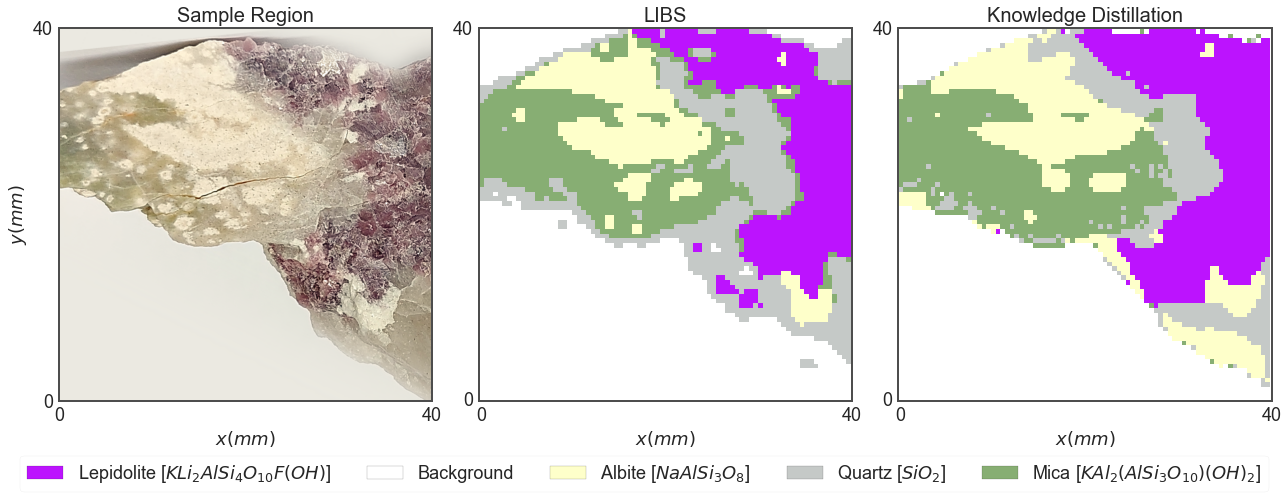

In [102]:
fig, ax = subplots(1, 3, figsize = (18, 8))

nx, ny = 80, 80

axs = ax[0]
axs.imshow(np.array(Image.open("C:/Users/tomas/Desktop/Tomás/Thesis/Data/image_bife.png"))[300:1700, 200:1600][::, ::-1][::, ::-1], origin = 'lower')
axs.grid(False)
axs.set_title('Sample Region', fontsize = 20)
axs.set_xlabel(r'$x(mm)$',fontsize=18)
axs.set_ylabel(r'$y(mm)$',fontsize=18)
axs.set_xticks([0,1400])
axs.set_xticklabels([0,int(nx/2)],fontsize=18)
axs.set_yticks([0,1400])
axs.set_yticklabels([0,int(nx/2)],fontsize=18)

axs = ax[2]
axs.imshow(pls_pred.reshape(nx, ny).T[::-1, ::][::, ::-1], cmap = cmp_init, origin = 'lower')
axs.set_title('Knowledge Distillation', fontsize = 20)
axs.grid(False)
axs.set_xlabel(r'$x(mm)$',fontsize=18)
# axs.set_ylabel(r'$y(mm)$',fontsize=18)
axs.set_xticks([0,nx])
axs.set_xticklabels([0,int(nx/2)],fontsize=18)
axs.set_yticks([0,nx])
axs.set_yticklabels([0,int(nx/2)],fontsize=18)

axs = ax[1]
axs.imshow(cluster_index.reshape(nx, ny).T[::-1, ::][::, ::-1], cmap = cmp_init, origin = 'lower')
axs.set_title('LIBS', fontsize = 20)
axs.grid(False)
axs.set_xlabel(r'$x(mm)$',fontsize=18)
# axs.set_ylabel(r'$y(mm)$',fontsize=18)
axs.set_xticks([0,nx])
axs.set_xticklabels([0,int(nx/2)],fontsize=18)
axs.set_yticks([0,nx])
axs.set_yticklabels([0,int(nx/2)],fontsize=18)

# fig.set_facecolor("white")
# fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0),
#           fancybox=True, shadow=True, ncol=5, fontsize = 16)

minerals = [r'Lepidolite [$KLi_2AlSi_4O_{10}F(OH)$]',r'Background',r'Albite [$NaAlSi_3O_8$]',r'Quartz [$SiO_2$]',r'Mica [$KAl_2(AlSi_3O_{10})(OH)_2$]']
colors = ['xkcd:neon purple', 'xkcd:white',  'xkcd:ecru' , 'xkcd:silver','xkcd:sage']
handles = []

hls = []
for color,mineral in zip(colors,minerals):
    patch = mpatches.Patch(color=color, label=mineral,ec='k')
    hls.append(patch)

fig.legend(handles=hls,loc = 'lower center',ncol=5, fontsize = 18)
fig.tight_layout()

# fig.savefig(r'C:/Users/tomas/Desktop/new_images/train_knowledge_distillation_new.jpg', dpi = 500, bbox_inches='tight')

## Generalization

In [73]:
end_band = -20
ffs = noise.SavitzkyGolay().denoise_bands(corrected_nparr[100:250, 100:320, :end_band], 5, 3) 
ffs = np.array(ffs)
index = np.where(ffs < 0.1) 
ffs[index] = 0

In [74]:
bands = data_ref.bands.centers

end_band = -20

feats_wls = []
signals = [np.ndarray.flatten(ffs[ii,jj,:]) for ii in range(0, ffs.shape[0]) for jj in range(0, ffs.shape[1]) ]

for xy in tqdm(range(0, len(signals))):
    #print('\r', xy, ' of ', str(len(signals)), end='')
    
    try:
        norm, x_hull, y_hull = spectro.convex_hull_removal(signals[xy], bands[ :end_band])
        features = spectro.FeaturesConvexHullQuotient(list(signals[xy]), bands[:end_band], startContinuum = None,
                                                     stopContinuum = None, baseline = 0.8, normalize = False)
        current_depth = 0
        current_wvl = 0
        for f in range(0, features.get_number_of_kept_features()):
            feat = features.features[f]
            if feat['abs_wvl'] > 2000 and feat['abs_depth'] > current_depth:
                current_wvl = feat['abs_wvl']
                current_depth = feat['abs_depth']
    except: 
        current_wvl = 0
        norm = signals[xy]
    
    feats_wls.append(current_wvl)
    signals[xy] = norm

100%|██████████| 33000/33000 [04:07<00:00, 133.21it/s]


In [75]:
s_signals = np.array(signals)
index = np.where(np.isnan(s_signals))
s_signals[index] = 1 #Maybe some bug taking data that made some points nan...setting them to 1

new_signals = np.array(s_signals).reshape((ffs.shape[0], ffs.shape[1], len(s_signals[0])))

#We need to get each wavelenght as a feature
full_list_of_wvls = np.array([np.ndarray.flatten(new_signals[:, :, i]) for i in range(0, len(new_signals[0, 0, :]))]).T

In [76]:
filen = 'Cavali_amostras_test_A2_2022-05-31_12-38-48'
folder = 'C:/Users/tomas/Desktop/Tomás/Thesis/CavaliHyper/SWIR_' + filen + '/capture/'


dark_ref = envi.open(folder+'DARKREF_SWIR_' + filen + '.hdr', 
                     folder+'DARKREF_SWIR_' + filen + '.raw')
white_ref = envi.open(folder+'WHITEREF_SWIR_' + filen + '.hdr', 
                      folder+'WHITEREF_SWIR_' + filen + '.raw')
data_ref = envi.open(folder+'SWIR_' + filen + '.hdr', 
                     folder+'SWIR_' + filen + '.raw')

c:\Users\tomas\Anaconda3\lib\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


In [77]:
white_nparr = np.array(white_ref.load())
dark_nparr = np.array(dark_ref.load())
data_nparr = np.array(data_ref.load())
print(white_nparr.shape,dark_nparr.shape, data_nparr.shape)

corrected_nparr = np.divide(data_nparr-dark_nparr.mean(axis=0),white_nparr.mean(axis=0)-dark_nparr.mean(axis=0)) #from reference

(100, 384, 284) (100, 384, 284) (354, 384, 284)


c:\Users\tomas\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
c:\Users\tomas\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


In [78]:
test_hyper = corrected_nparr[45:250, 50:370, :]

end_band = -20
ffs = noise.SavitzkyGolay().denoise_bands(test_hyper[:, :, :end_band], 5, 3) 
ffs = np.array(ffs)
index = np.where(ffs < 0.1) 
ffs[index] = 0

In [79]:
bands = data_ref.bands.centers

end_band = -20

feats_wls = []
signals = [np.ndarray.flatten(ffs[ii,jj,:]) for ii in range(0, ffs.shape[0]) for jj in range(0, ffs.shape[1]) ]

for xy in tqdm(range(0, len(signals))):
    #print('\r', xy, ' of ', str(len(signals)), end='')
    
    try:
        norm, x_hull, y_hull = spectro.convex_hull_removal(signals[xy], bands[ :end_band])
        features = spectro.FeaturesConvexHullQuotient(list(signals[xy]), bands[:end_band], startContinuum = None,
                                                     stopContinuum = None, baseline = 0.8, normalize = False)
        current_depth = 0
        current_wvl = 0
        for f in range(0, features.get_number_of_kept_features()):
            feat = features.features[f]
            if feat['abs_wvl'] > 2000 and feat['abs_depth'] > current_depth:
                current_wvl = feat['abs_wvl']
                current_depth = feat['abs_depth']
    except: 
        current_wvl = 0
        norm = signals[xy]
    
    feats_wls.append(current_wvl)
    signals[xy] = norm

100%|██████████| 65600/65600 [10:16<00:00, 106.39it/s]


In [80]:
s_signals = np.array(signals)
index = np.where(np.isnan(s_signals))
s_signals[index] = 1 #Maybe some bug taking data that made some points nan...setting them to 1

new_signals = np.array(s_signals).reshape((ffs.shape[0], ffs.shape[1], len(s_signals[0])))

#We need to get each wavelenght as a feature
train_list_of_wvls = np.array([np.ndarray.flatten(new_signals[:, :, i]) for i in range(0, len(new_signals[0, 0, :]))]).T

In [81]:
full_train_data_other = StandardScaler().fit_transform(train_list_of_wvls)
full_train_data = StandardScaler().fit_transform(full_list_of_wvls)

# PCA-Kmeans
pcs = pca_pip.transform(train_list_of_wvls)
pca_km_pred_other = kmean_pip.predict(pcs)

pcs = pca_pip.transform(full_list_of_wvls)
pca_km_pred = kmean_pip.predict(pcs)

# PCA-DA
pls_da_pred =  plsr.predict(full_list_of_wvls).argmax(axis = 1)

pls_da_pred_other = plsr.predict(train_list_of_wvls).argmax(axis = 1)

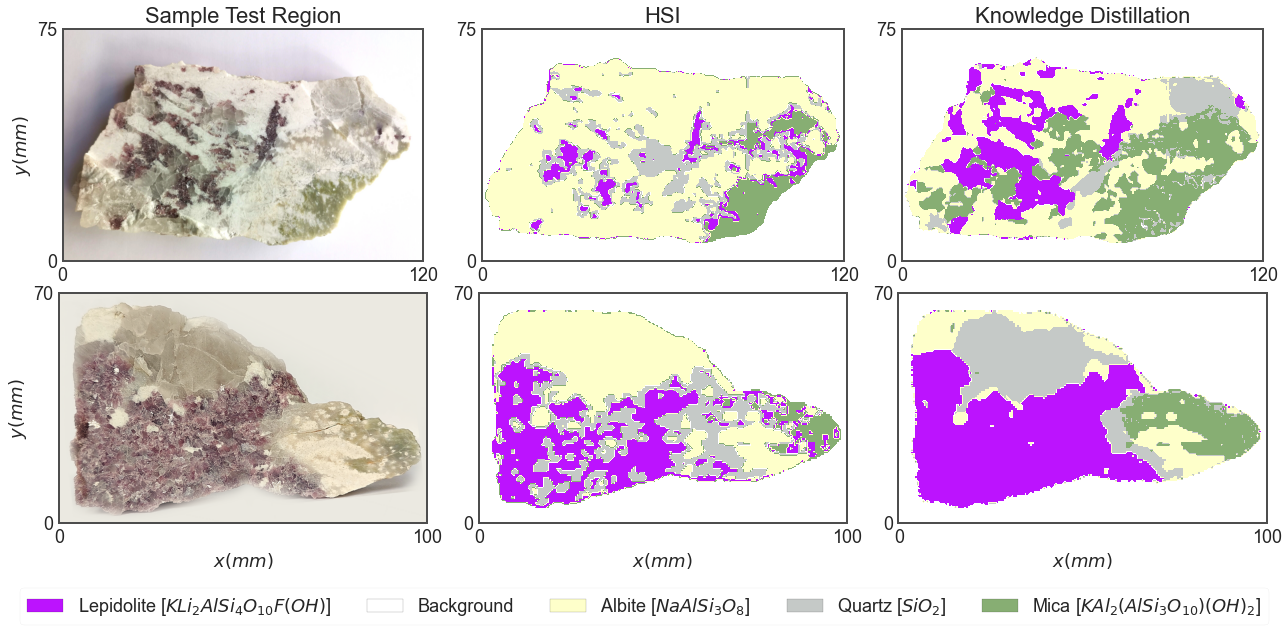

In [90]:
fig, ax = subplots(2, 3, figsize = (18, 8))

# colors = ['Purple', 'ghostwhite',  'lightgoldenrodyellow' , 'silver','darkseagreen']
colors = ['xkcd:neon purple', 'xkcd:white',  'xkcd:ecru' , 'xkcd:silver','xkcd:sage']

axs = ax[0, 0]
axs.imshow(np.array(Image.open("C:/Users/tomas/Desktop/Tomás/Thesis/IMG_20230302_153550.jpg"))[::, ::-1][450:2635, 0:3400][::, ::-1], origin = 'lower')
axs.set_title("Sample Test Region", fontsize = 22)
axs.grid(False)
axs.set_ylabel(r'$y(mm)$',fontsize=18)
axs.set_xticks([0,3400])
axs.set_xticklabels([0,120],fontsize=18)
axs.set_yticks([0,2185])
axs.set_yticklabels([0,75],fontsize=18)

axs = ax[0, 1]
axs.imshow(pca_km_pred_other.reshape(205, 320)[::-1, ::][::, ::-1], cmap = cmp_hsi, origin = 'lower')
axs.set_title("HSI", size = 22)
axs.grid(False)
axs.set_xticks([0,320])
axs.set_xticklabels([0,120],fontsize=18)
axs.set_yticks([0,205])
axs.set_yticklabels([0,75],fontsize=18)

axs = ax[0, 2]
axs.imshow(pls_da_pred_other.reshape(205, 320)[::-1, ::][::, ::-1], cmap = cmp_init, origin = 'lower')
axs.set_title("Knowledge Distillation", size = 22)
axs.grid(False)
axs.set_xticks([0,320])
axs.set_xticklabels([0,120],fontsize=18)
axs.set_yticks([0,205])
axs.set_yticklabels([0,75],fontsize=18)

axs = ax[1, 0]
axs.imshow(np.array(Image.open("C:/Users/tomas/Desktop/Tomás/Thesis/Data/image_bife.png"))[::-1, ::][::, ::-1], origin = 'lower')
# axs.set_title("Sample Testing Region", fontsize = 20)
axs.grid(False)
axs.set_xlabel(r'$x(mm)$',fontsize=18)
axs.set_ylabel(r'$y(mm)$',fontsize=18)
axs.set_xticks([0,2965])
axs.set_xticklabels([0,100],fontsize=18)
axs.set_yticks([0,1855])
axs.set_yticklabels([0,70],fontsize=18)

axs = ax[1, 1]
axs.imshow(pca_km_pred.reshape(150, 220)[::-1, ::][20:142, 20:215][::, ::-1], cmap = cmp_hsi, origin = 'lower')
axs.grid(False)
axs.set_xlabel(r'$x(mm)$',fontsize=18)
axs.set_xticks([0,195])
axs.set_xticklabels([0,100],fontsize=18)
axs.set_yticks([0,122])
axs.set_yticklabels([0,70],fontsize=18)

axs = ax[1, 2]
axs.imshow(pls_da_pred.reshape(150, 220)[::-1, ::][20:142, 20:215][::, ::-1], cmap = cmp_init, origin = 'lower')
axs.grid(False)
axs.set_xlabel(r'$x(mm)$',fontsize=18)
axs.set_xticks([0,195])
axs.set_xticklabels([0,100],fontsize=18)
axs.set_yticks([0,122])
axs.set_yticklabels([0,70],fontsize=18)

hls = []
for color,mineral in zip(colors,minerals):
    patch = mpatches.Patch(color=color, label=mineral,ec='k')
    hls.append(patch)

fig.legend(handles = hls, loc = 'lower center', ncol = 5, fontsize = 18, bbox_to_anchor = (0.5, -0.10))

fig.tight_layout()
# fig.savefig(r'C:/Users/tomas/Desktop/new_images/results_kd_new.png', dpi = 500, bbox_inches='tight')